In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import calendar
import xgboost as xgb
import warnings
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score as R2
from sklearn.svm import SVR
from mlxtend.regressor import StackingRegressor
from tqdm import tqdm

# Plot styling
bcg_green='#29BA74'
contrast='#E82960'
charbon='#4D4D4D'
other_green='#A8B21C'

sns.set_style("dark")
sns.set_palette('Greens_r')
sns.set(rc={'axes.facecolor':'#EAEAEA','figure.facecolor':'#EAEAEA', 'text.color':charbon, 'xtick.color':charbon, 'ytick.color':charbon, 'axes.labelcolor':charbon})
sns.set_context('talk')

# Homemade functions
from utils.create_lag_features import create_lag_features
from utils.periods import add_periods

def plot_calculate_errors(model_name, model, n, train_data, test_data, test_dates, plot=True):
    if plot:
        plt.figure( figsize = (35,25))
    
    relative_errors = []
    errors = []
    r2_list = []
    errors = []
    models = []
    for i, (X_train, y_train) in tqdm(enumerate(train_data)):
        search = model.fit(X_train, y_train)
        models.append(model)
        y_pred = model.predict(test_data[i][0])
        error = MSE(test_data[i][1], y_pred)**(1/2)
        r2 = R2(test_data[i][1], y_pred)
        
        if plot:
            ax = plt.subplot(n//2+1,2,i+1)
    
            # plot test and prediction values 
            #plt.plot(test_dates[i], y_pred, label = 'prediction')
            #plt.plot(test_dates[i], test_data[i][1], label = 'test', alpha = 0.5)
            ax.plot(test_dates[i],y_pred, label = 'prediction', color=bcg_green, alpha=0.8)
            ax.fill_between(ax.lines[0].get_xydata()[:,0], ax.lines[0].get_xydata()[:,1], alpha=0.3, color=bcg_green)
            ax.plot(test_dates[i], test_data[i][1], label = 'test',  alpha=0.8, color=other_green)
            ax.fill_between(ax.lines[1].get_xydata()[:,0], ax.lines[1].get_xydata()[:,1], alpha=0.3, color=other_green)
            ax.grid(False)
            ax.spines['left'].set_color(charbon)
            ax.spines['bottom'].set_color(charbon)
            sns.despine(ax=ax,top=True, right=True, left=False, bottom=False)

            # [Optional] Some extra details
            #  diff = y_pred_xg.reshape(test_data[i][1].shape) - test_data[i][1]
            #  plt.plot(test_dates[i],(diff**2)**(1/2))
            
            plt.ylabel(target)
            plt.title(target + ' (prediction x real data)', size=24)
            plt.xticks(rotation = 45)
            plt.legend()
            
            if i == n - 1:
                y_pred = model.predict(X_next_week)
                ax = plt.subplot(n//2+1,2,i+2)
    
                # plot test and prediction values 
                ax.plot(next_week_dates, y_pred, label = 'prediction', color=bcg_green, alpha=0.8)

                # [Optional] Some extra details
                #  diff = y_pred_xg.reshape(test_data[i][1].shape) - test_data[i][1]
                #  plt.plot(test_dates[i],(diff**2)**(1/2))

                plt.ylabel(target)
                plt.title(target + ' (prediction x real data)', size=24)
                plt.xticks(rotation = 45)
                plt.tight_layout()
                plt.legend()
            
        relative_error = error/df_analysis[target].mean()
        errors.append(error)
        relative_errors.append(relative_error)
        r2_list.append(r2)
    
    plt.show()

    print(" [+] Model Name:", model_name)
    print(' [.] RMSE: {}'.format(str(errors)))
    print(' [.] RMSE mean: {}'.format(float(np.mean(errors))))
    print(' [.] Relative RMSE: {}'.format(str(relative_errors)))
    print(' [.] Relative RMSE Mean: {:.2%}'.format(float(np.mean(relative_errors))))
    print(' [.] R^2: {}'.format(str(r2_list)))
    print(' [.] R^2 Mean: {:.2%}'.format(float(np.mean(r2_list))))
    print("-----------------------------------------------------")
    
    rmse_mean[model_name] = float(np.mean(errors))
    relative_rmse_mean[model_name] = float(np.mean(relative_errors))
    r2_mean[model_name] = float(np.mean(r2_list))

    return models

def plot_calculate_errors_stack(model_name, model, n, train_data, test_data, test_dates, plot=True):
    if plot:
        plt.figure( figsize = (35,25))
    
    relative_errors = []
    errors = []
    r2_list = []
    errors = []
    models = []
    next_week_pred = []
    for i, (X_train, y_train) in tqdm(enumerate(train_data)):
        model.fit(X_train, y_train)
        models.append(model)
        
        y_pred = model.predict(test_data[i][0]).clip(min=0)
        error = MSE(test_data[i][1], y_pred)**(1/2)
        r2 = R2(test_data[i][1], y_pred)
        
        if plot:
            ax = plt.subplot(n//2+1,2,i+1)
    
            # plot test and prediction values 
            #plt.plot(test_dates[i], y_pred, label = 'prediction')
            #plt.plot(test_dates[i], test_data[i][1], label = 'test', alpha = 0.5)
            ax.plot(test_dates[i],y_pred, label = 'prediction', color=bcg_green, alpha=0.8)
            ax.fill_between(ax.lines[0].get_xydata()[:,0], ax.lines[0].get_xydata()[:,1], alpha=0.3, color=bcg_green)
            ax.plot(test_dates[i], test_data[i][1], label = 'test',  alpha=0.8, color=other_green)
            ax.fill_between(ax.lines[1].get_xydata()[:,0], ax.lines[1].get_xydata()[:,1], alpha=0.3, color=other_green)
            ax.grid(False)
            ax.spines['left'].set_color(charbon)
            ax.spines['bottom'].set_color(charbon)
            sns.despine(ax=ax,top=True, right=True, left=False, bottom=False)

            # [Optional] Some extra details
            #  diff = y_pred_xg.reshape(test_data[i][1].shape) - test_data[i][1]
            #  plt.plot(test_dates[i],(diff**2)**(1/2))
            
            plt.ylabel(target)
            plt.title(target + ' (prediction x real data)', size=24)
            plt.xticks(rotation = 45)
            plt.tight_layout()
            plt.legend()
            
            if i == n - 1:
                y_pred = model.predict(X_next_week).clip(min=0)
                plt.subplot(n//2 + 1, 2, i+2)
    
                # plot test and prediction values 
                plt.plot(next_week_dates, y_pred, label = 'prediction', color=bcg_green, alpha=0.8)

                # [Optional] Some extra details
                #  diff = y_pred_xg.reshape(test_data[i][1].shape) - test_data[i][1]
                #  plt.plot(test_dates[i],(diff**2)**(1/2))

                plt.ylabel(target)
                plt.title(target + ' (prévision x real data)', size=24)
                plt.xticks(rotation = 45)
                plt.legend()

                next_week_pred = pd.DataFrame(next_week_dates, columns=['Date et heure de comptage'])
                next_week_pred[target] = y_pred
            
        relative_error = error/df_analysis[target].mean()
        errors.append(error)
        relative_errors.append(relative_error)
        r2_list.append(r2)
    
    plt.show()

    print(" [+] Model Name:", model_name)
    print(' [.] RMSE: {}'.format(str(errors)))
    print(' [.] RMSE mean: {}'.format(float(np.mean(errors))))
    print(' [.] Relative RMSE: {}'.format(str(relative_errors)))
    print(' [.] Relative RMSE Mean: {:.2%}'.format(float(np.mean(relative_errors))))
    print(' [.] R^2: {}'.format(str(r2_list)))
    print(' [.] R^2 Mean: {:.2%}'.format(float(np.mean(r2_list))))
    print("-----------------------------------------------------")
    
    rmse_mean[model_name] = float(np.mean(errors))
    relative_rmse_mean[model_name] = float(np.mean(relative_errors))
    r2_mean[model_name] = float(np.mean(r2_list))

    return models, next_week_pred


def read_csvs(years):
    df_convention = pd.DataFrame()
    df_washington = pd.DataFrame()
    df_sts = pd.DataFrame()
    for year in years:
        append_convention = pd.read_csv('./clean_opendata/' + year + '/convention.csv')
        df_convention = df_convention.append(append_convention)
        append_washington = pd.read_csv('./clean_opendata/' + year + '/washington.csv')
        df_washington = df_washington.append(append_washington)
        append_sts = pd.read_csv('./clean_opendata/' + year + '/sts.csv')
        df_sts = df_sts.append(append_sts)
        
    return df_convention, df_washington, df_sts


def separate_last_n_weeks(n, df_analysis, X, y):
    test_dates = []
    train_data = []
    test_data = []
    for i in range(n, 0, -1):
        train_data.append((X[:-7*i*24], y[:-7*i*24]))
        test_data.append((X[-7*i*24:][:7*24], y[-7*i*24:][:7*24]))
        test_dates.append(df_analysis['Date et heure de comptage'].iloc[-7*i*24:].iloc[:7*24])

    return train_data, test_data, test_dates

In [2]:
start_date_knn = '2016-01-01'
end_date_knn = '2020-12-11'

start_date_xgboost = '2020-05-12'
end_date_xgboost = '2020-12-11'

dataset = "convention"      # {"sts", "convention", "washington"}
target = "Taux d'occupation"    # {"Débit horaire", "Taux d'occupation"}
n = 4                       # number of weeks to test

rmse_mean = dict()
relative_rmse_mean = dict()
r2_mean = dict()

years = ['2016', '2017','2018','2019', '2020']

In [3]:
print("**********************************")
print("             Metadata")
print("**********************************")

print(" [.] Start date KNN:", start_date_knn)
print(" [.] End date KNN:", end_date_knn)
print(" [.] Start date xgboost:", start_date_xgboost)
print(" [.] End date xgboost:", end_date_xgboost)
print(" [.] Dataset:", dataset)
print(" [.] Target:", target)
print(" [.] N. tests:", n)

**********************************
             Metadata
**********************************
 [.] Start date KNN: 2016-01-01
 [.] End date KNN: 2020-12-11
 [.] Start date xgboost: 2020-05-12
 [.] End date xgboost: 2020-12-11
 [.] Dataset: convention
 [.] Target: Taux d'occupation
 [.] N. tests: 4


In [4]:
df_convention, df_washington, df_sts = read_csvs(years)

df_convention['Date et heure de comptage'] = pd.to_datetime(df_convention['Date et heure de comptage'])
df_washington['Date et heure de comptage'] = pd.to_datetime(df_washington['Date et heure de comptage'])
df_sts['Date et heure de comptage'] = pd.to_datetime(df_sts['Date et heure de comptage'])

if dataset == 'convention':
    df_analysis = df_convention.copy()
elif dataset == 'sts':
    df_analysis = df_sts.copy()
elif dataset == 'washington':
    df_analysis = df_washington.copy()
else:
    print(" [Error] Invalid dataset")

begin_date = '2020-12-11'
next_week = pd.DataFrame({'Date et heure de comptage':pd.date_range(begin_date, periods=144, freq='1H')})
df_analysis = pd.concat([df_analysis, next_week])

df_analysis = df_analysis[['Date et heure de comptage', target]]
df_analysis['year'] = df_analysis['Date et heure de comptage'].dt.year.astype('category')
df_analysis['month'] = df_analysis['Date et heure de comptage'].dt.month.astype('category')
df_analysis['week_day'] = df_analysis['Date et heure de comptage'].dt.weekday.astype('category')
df_analysis['time'] = df_analysis['Date et heure de comptage'].dt.time.astype(str).apply(lambda x: x[:2]).astype('category')
df_analysis.sort_values('Date et heure de comptage', inplace=True)
df_analysis.reset_index(inplace = True)

df_analysis = add_periods(df_analysis)

# Add lag features
# df_analysis = create_lag_features(df_analysis, target, [6*24])

df_analysis_dummies = pd.get_dummies(df_analysis)
next_week = df_analysis_dummies[-144:]
df_analysis_dummies = df_analysis_dummies[:-144]

df_analysis_dummies.dropna(inplace=True)
df_analysis_dummies.set_index('Date et heure de comptage', inplace=True)

# filter dates
df_analysis_knn_dummies = df_analysis_dummies[start_date_knn:end_date_knn]
df_analysis_xgboost_dummies = df_analysis_dummies[start_date_xgboost:end_date_xgboost]

y_knn = df_analysis_knn_dummies[[target]].values
y_xgboost = df_analysis_xgboost_dummies[[target]].values

df_analysis_knn_dummies.reset_index(inplace = True)
df_analysis_xgboost_dummies.reset_index(inplace = True)

dates_knn = df_analysis_knn_dummies['Date et heure de comptage']
dates_xgboost = df_analysis_xgboost_dummies['Date et heure de comptage']

X_knn = df_analysis_knn_dummies.drop(columns = ['Date et heure de comptage', target, 'index']).values
X_xgboost = df_analysis_xgboost_dummies.drop(columns = ['Date et heure de comptage', target, 'index']).values

train_data_knn, test_data_knn, test_dates_knn = separate_last_n_weeks(n, df_analysis_knn_dummies, X_knn, y_knn)
train_data_xgboost, test_data_xgboost, test_dates_xgboost = separate_last_n_weeks(n, df_analysis_xgboost_dummies, X_xgboost, y_xgboost)

min_max_scaler = MinMaxScaler()

In [5]:
next_week_dates = next_week[['Date et heure de comptage']]
X_next_week = next_week.drop(columns=['Date et heure de comptage', target, 'index']).values

## KNN

In [6]:
knn_regressor = KNeighborsRegressor(n_neighbors = 3)
pl_knn = make_pipeline(min_max_scaler, knn_regressor)

4it [00:14,  3.73s/it]


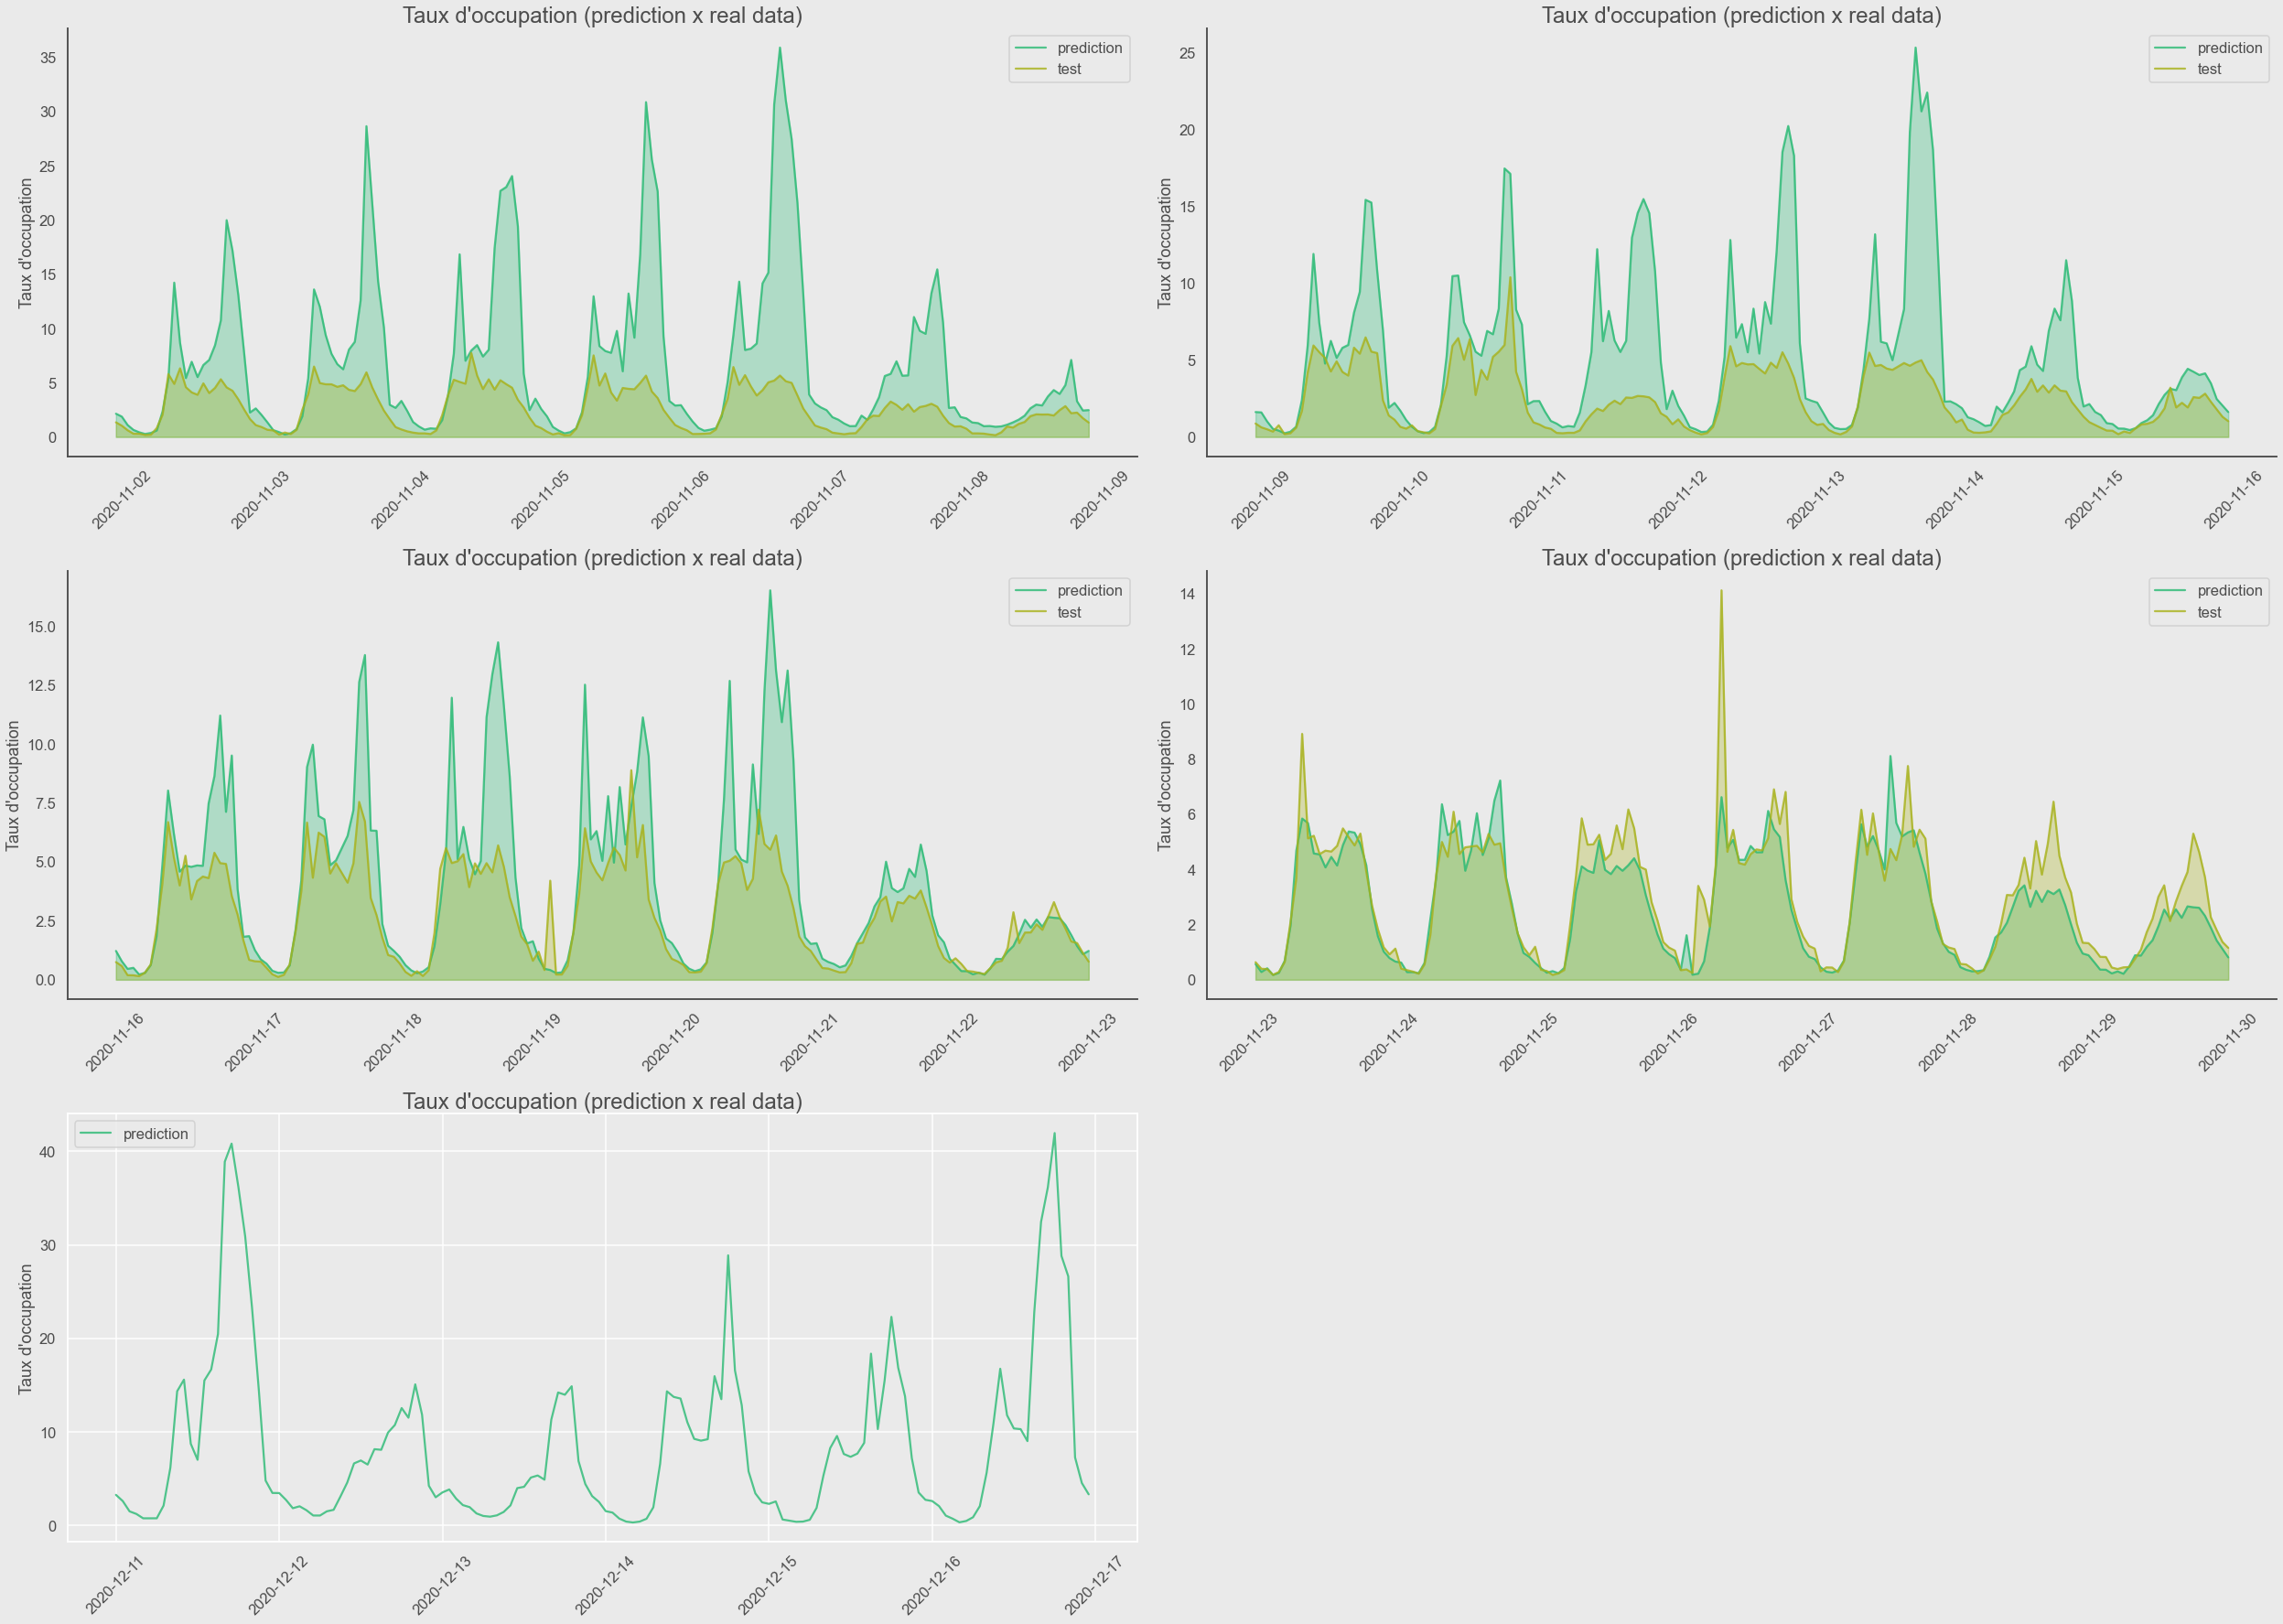

 [+] Model Name: KNN
 [.] RMSE: [7.542925637285113, 4.959432637722139, 2.6834243100967816, 1.0944855291463265]
 [.] RMSE mean: 4.0700670285625895
 [.] Relative RMSE: [1.1041894453241101, 0.725998562984601, 0.39281956935763446, 0.1602189160356516]
 [.] Relative RMSE Mean: 59.58%
 [.] R^2: [-13.937260266046865, -5.554665455107985, -0.7107090579616824, 0.7499827661955445]
 [.] R^2 Mean: -486.32%
-----------------------------------------------------


In [7]:
KNNs = plot_calculate_errors("KNN", pl_knn, n, train_data_knn, test_data_knn, test_dates_knn)

## XGBOOST

In [8]:
xgboost = xgb.XGBRegressor(
        eval_metric = 'rmse',
        nthread = 4,
        eta = 0.1,
        max_depth = 5,
        subsample = 0.5,
        colsample_bytree = 1.0,
        )

parameters = {
     'max_depth': [2, 3, 4, 5],
     'learning_rate': [0.1, 0.2, 0.3, 0.4],
     'subsample': [0.7, 0.8],
     'reg_lambda': [1.0, 5.0, 10.0],
     'n_estimators': [100, 200]
}

xgboost_search = RandomizedSearchCV(xgboost, parameters, n_jobs=1, cv=5)
pl_xgboost = make_pipeline(min_max_scaler, xgboost_search)

ion_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederro

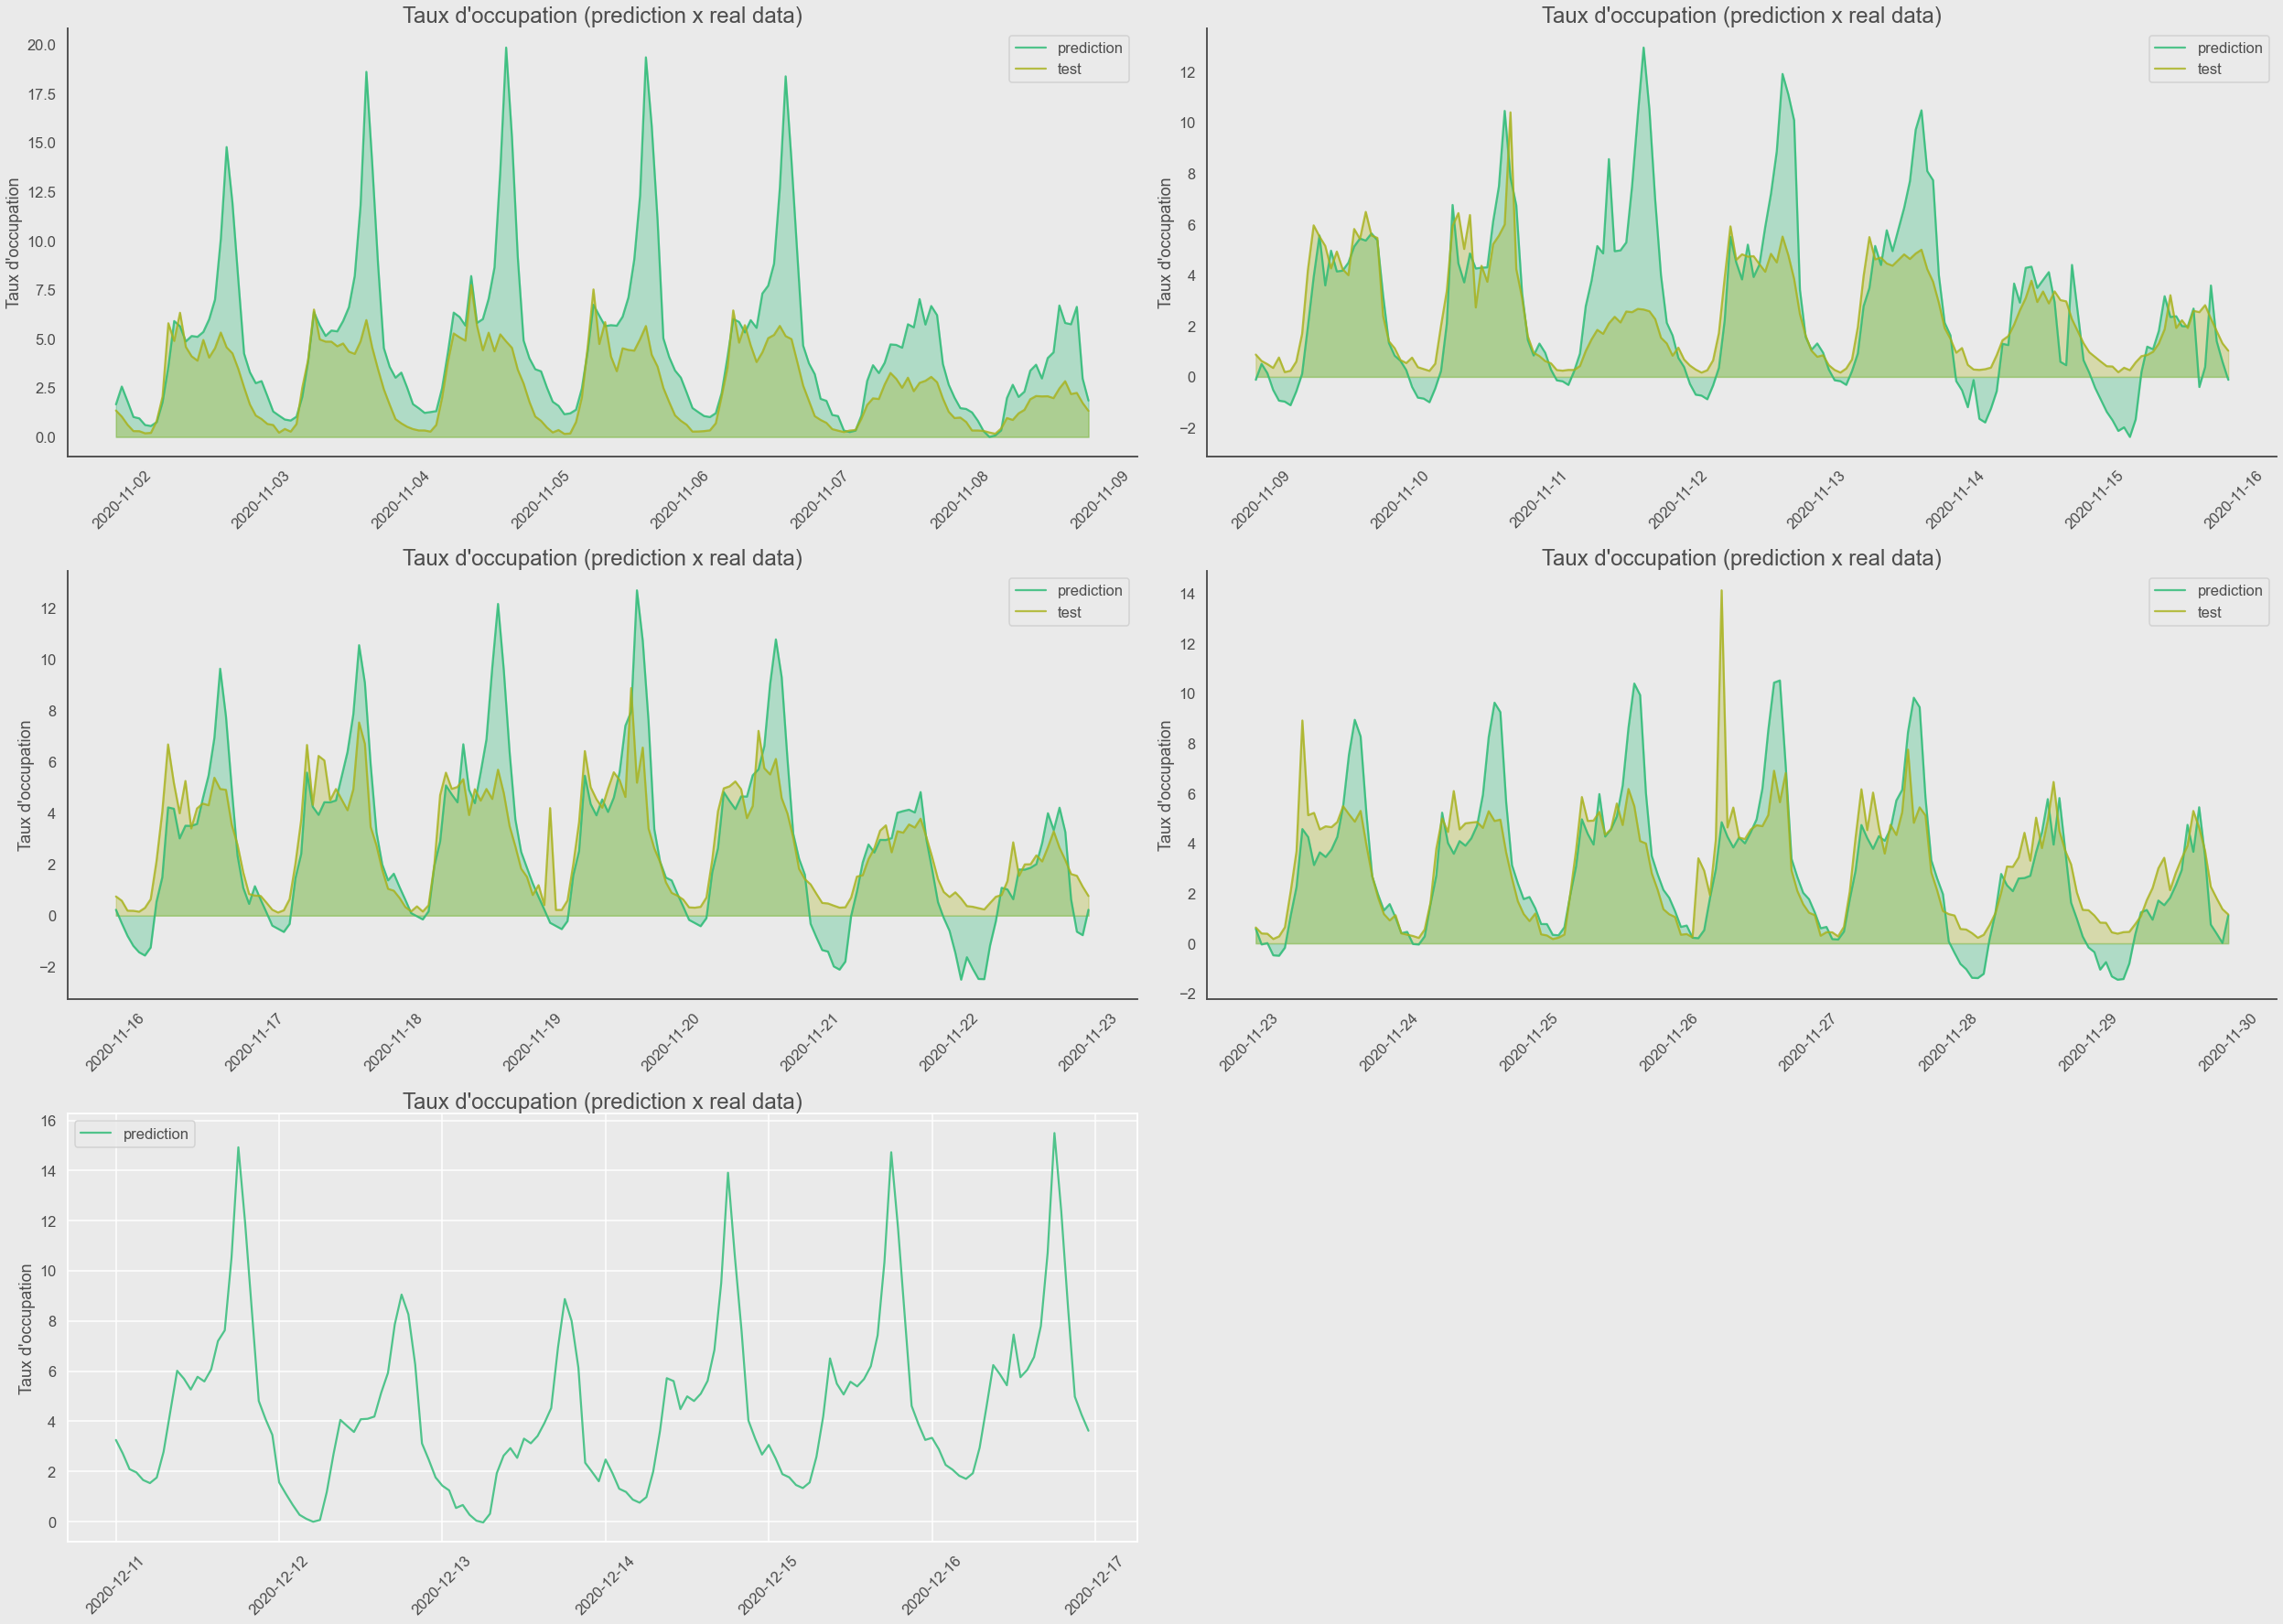

 [+] Model Name: xgboost
 [.] RMSE: [3.614461642505547, 2.2253077826148973, 1.78762809299529, 1.725253539761543]
 [.] RMSE mean: 2.338162764469319
 [.] Relative RMSE: [0.5291117250918506, 0.3257570715022139, 0.26168626967409886, 0.2525554195703851]
 [.] Relative RMSE Mean: 34.23%
 [.] R^2: [-2.4298769241651192, -0.3196741587231282, 0.24080769539245583, 0.37876523356308456]
 [.] R^2 Mean: -53.25%
-----------------------------------------------------


In [9]:
xgboosts = plot_calculate_errors("xgboost", pl_xgboost, n, train_data_xgboost, test_data_xgboost, test_dates_xgboost)

## Average Ensemble

In [10]:
#voting_regressor = VotingRegressor([('knn', pl_knn), ('xgboost', pl_xgboost)])

In [11]:
#knns_xgboosts = plot_calculate_errors("xgboost + KNN average ensemble", voting_regressor, n, train_data_xgboost, test_data_xgboost, test_dates_xgboost)

## Stacking Regressor Ensemble Linear Regression

In [12]:
regressors = [pl_xgboost, pl_knn]
stregrlr = StackingRegressor(regressors=regressors, 
                           meta_regressor=LinearRegression())

ion_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederro

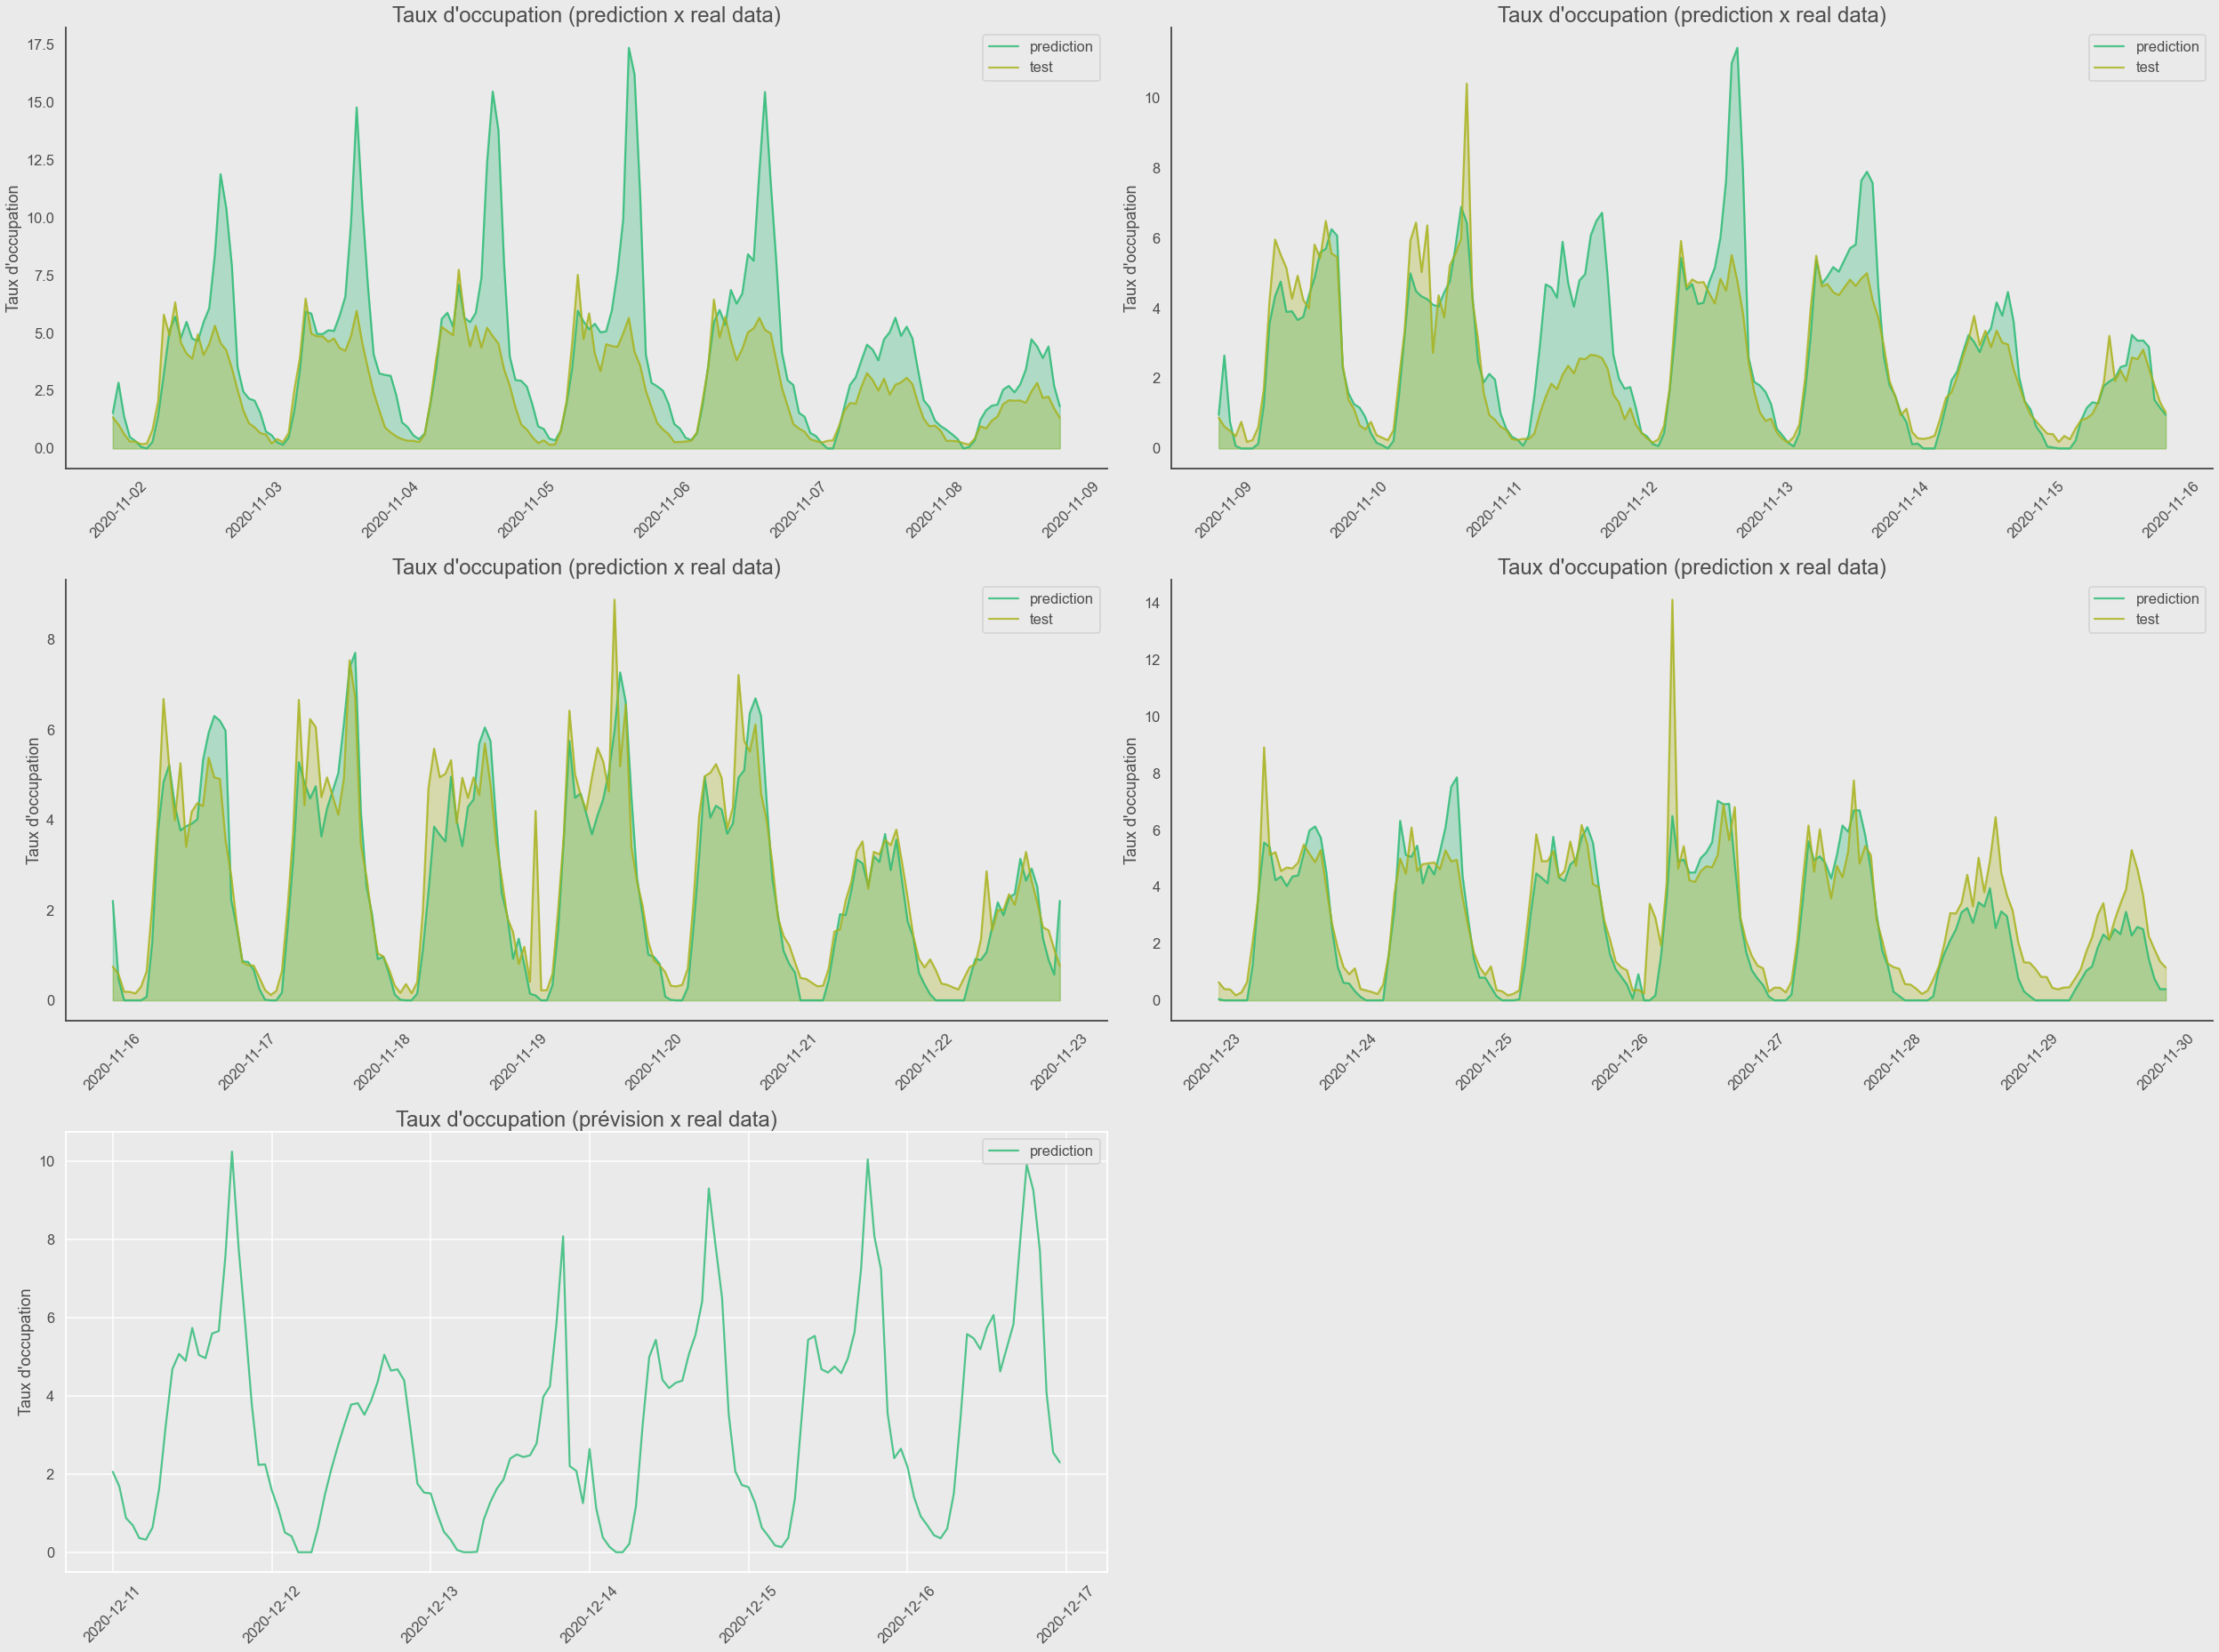

 [+] Model Name: xgboost + knn stacking regressor lr
 [.] RMSE: [2.8168679777556362, 1.3697506799774397, 0.8321554444947019, 1.1312724001931145]
 [.] RMSE mean: 1.537511625605223
 [.] Relative RMSE: [0.41235404397129105, 0.2005142720856765, 0.12181709098894987, 0.1656040512855044]
 [.] Relative RMSE Mean: 22.51%
 [.] R^2: [-1.0831679311374822, 0.500000478838881, 0.8354846699569821, 0.7328936077178068]
 [.] R^2 Mean: 24.63%
-----------------------------------------------------


In [13]:
ensembles_lr, next_week_pred = plot_calculate_errors_stack("xgboost + knn stacking regressor lr", stregrlr, n, train_data_xgboost, test_data_xgboost, test_dates_xgboost, plot=True)

## Result Analysis

In [14]:
df_rmse_mean = pd.DataFrame.from_dict(rmse_mean, orient='index')
df_rmse_mean.columns = ['RMSE mean']
df_rmse_mean.sort_values(by=['RMSE mean'], inplace=True, ascending=True)
df_rmse_mean

,RMSE mean
xgboost + knn stacking regressor lr,1.537512
xgboost,2.338163
KNN,4.070067


In [15]:
df_rel_rmse_mean = pd.DataFrame.from_dict(relative_rmse_mean, orient='index')
df_rel_rmse_mean.columns = ['Relative RMSE mean']
df_rel_rmse_mean.sort_values(by=['Relative RMSE mean'], inplace=True, ascending=True)
df_rel_rmse_mean

,Relative RMSE mean
xgboost + knn stacking regressor lr,0.225072
xgboost,0.342278
KNN,0.595807


In [16]:
df_r2_mean = pd.DataFrame.from_dict(r2_mean, orient='index')
df_r2_mean.columns = ['R^2 mean']
df_r2_mean.sort_values(by=['R^2 mean'], inplace=True, ascending=False)
df_r2_mean

,R^2 mean
xgboost + knn stacking regressor lr,0.246303
xgboost,-0.532495
KNN,-4.863163


## Generate Output

In [17]:
output_path = 'final/output/convention_taux.csv'
next_week_pred.to_csv(output_path, index=False)